In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from pathlib import Path
import copy
import logging
import sys

from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchao
import sentencepiece as spm
from lhotse.cut import CutSet
from lhotse.utils import LOG_EPSILON
import k2
from icefall.utils import add_sos
from icefall.lexicon import Lexicon
from icefall.utils import write_error_stats

sys.path.insert(0, "ema_norm")

from model import Transducer
from decode_korean_cer import get_parser, decode_dataset
from train import get_params, get_transducer_model
from keyword_spotting import get_model
from asr_datamodule import AsrDataModule

Skipping import of cpp extensions due to incompatible torch version 2.9.0+cu129 for torchao version 0.14.0         Please see GitHub issue #2919 for more info


In [ ]:
parser = get_parser()
AsrDataModule.add_arguments(parser)
args = parser.parse_args([
    '--channels', '256',
    '--channels-expansion', '1024',
    '--dilations-version', '11',
    '--kernel-size', '8',
    '--encoder-dropout', '0.075',
    '--encoder-activation', 'ReLU',
    '--encoder-se-activation', 'ReLU',
    '--encoder-norm', 'BatchNorm',
    '--decoder-dim', '256',
    '--joiner-dim', '256',
    '--act-bal', 'True',
    '--whitener', 'True',
    '--scale-limit', '2.0',
    '--ema-gamma', '0.93',  
    '--chunksize', '16',
    '--bpe-model', "data/ko/lang_bpe_500_ipa_filtered/bpe.model",
    '--epoch', '97',
    '--avg', '32',
    '--exp-dir', 'exp/ko/ipa_do_sl0.5',
    '--data-libri-train', 'False',
    '--data-ksponspeech-train', 'True',
    '--data-ksponspeech-eval-clean', 'True',
    '--data-ksponspeech-eval-other', 'True',
    '--data-zeroth-test', 'True',
    '--on-the-fly-feats', 'True',
    '--manifest-dir', 'data/ko/fbank',
    '--cutset-text', 'custom.ipa_filtered',
    '--decoding-method', 'fast_beam_search',
])

In [25]:
parser = get_parser()
AsrDataModule.add_arguments(parser)
args = parser.parse_args([
    '--channels', '256',
    '--channels-expansion', '1024',
    '--dilations-version', '11',
    '--kernel-size', '8',
    '--encoder-dropout', '0.075',
    '--encoder-activation', 'ReLU',
    '--encoder-se-activation', 'ReLU',
    '--encoder-norm', 'BatchNorm',
    '--decoder-dim', '256',
    '--joiner-dim', '256',
    '--scale-limit', '2.0',
    '--ema-gamma', '0.93',  
    '--chunksize', '8',
    "--bpe-model", "data/en/lang_bpe_500/bpe.model",
    '--epoch', '3',
    '--avg', '1',
    '--exp-dir', 'exp/en/norm_bypass_chunk8_ipa3',
    '--data-libri-train', 'True',
    '--data-libri-test-clean', 'True',
    '--manifest-dir', 'data/en/fbank',
    '--cutset-text', 'text',
    '--decoding-method', 'fast_beam_search',
    '--use-averaged-model', 'False',
    '--max-duration', '4000',
])

In [26]:
args.exp_dir = Path(args.exp_dir)
params = get_params()
params.update(vars(args))

sp = spm.SentencePieceProcessor()
sp.load(params.bpe_model)
params.blank_id = sp.piece_to_id("<blk>")
params.unk_id = sp.piece_to_id("<unk>")
params.vocab_size = sp.get_piece_size()
logging.basicConfig(
    format="%(asctime)s %(levelname)s [%(filename)s:%(lineno)d] %(message)s",
    level=logging.INFO
)

In [5]:
device = "cuda"
dtype = torch.float32

In [27]:
# Prepare model
model = get_transducer_model(params)
get_model(params, model, device, sp, params.exp_dir / f"epoch-{params.epoch}-avg-{params.avg}.pt")
model.eval()
# model.encoder.remove_weight_reparameterizations(fuse_bn=False)
# model.decoder.remove_weight_reparameterizations()
# model.joiner.remove_weight_reparameterizations()
model.to(device=device, dtype=dtype)

# Prepare data
datamodule = AsrDataModule(params)
train_dl = datamodule.get_train_dataloader(params, sp)
test_dl_dict = datamodule.get_test_dataloader_dict(params)
if "fast_beam_search" in params.decoding_method:
    if params.decoding_method == "fast_beam_search_nbest_LG":
        lexicon = Lexicon(params.lang_dir)
        word_table = lexicon.word_table
        lg_filename = params.lang_dir / "LG.pt"
        logging.info(f"Loading {lg_filename}")
        decoding_graph = k2.Fsa.from_dict(
            torch.load(lg_filename, map_location=device)
        )
        decoding_graph.scores *= params.ngram_lm_scale
    else:
        word_table = None
        decoding_graph = k2.trivial_graph(params.vocab_size - 1, device=device)
else:
    decoding_graph = None
    word_table = None

2025-11-20 15:48:48,150 INFO [checkpoint.py:112] Loading checkpoint from exp/en/norm_bypass_chunk8_ipa3/epoch-3.pt


Sequential(
  (0): Identity()
  (1): Identity()
  (2): ScaledConv1d(256, 512, kernel_size=(1,), stride=(1,), bias=False)
)


2025-11-20 15:48:49,105 INFO [asr_datamodule.py:624] About to get train-clean-100 cuts
2025-11-20 15:48:49,108 INFO [asr_datamodule.py:631] About to get train-clean-360 cuts
2025-11-20 15:48:49,110 INFO [asr_datamodule.py:638] About to get train-other-500 cuts
2025-11-20 15:48:49,117 INFO [asr_datamodule.py:438] Enable MUSAN
2025-11-20 15:48:49,118 INFO [asr_datamodule.py:439] About to get Musan cuts


load checkpoint 3


2025-11-20 15:48:51,173 INFO [asr_datamodule.py:463] Enable SpecAugment
2025-11-20 15:48:51,174 INFO [asr_datamodule.py:464] Time warp factor: 80
2025-11-20 15:48:51,175 INFO [asr_datamodule.py:474] Num frame mask: 10
2025-11-20 15:48:51,176 INFO [asr_datamodule.py:487] About to create train dataset
2025-11-20 15:48:51,177 INFO [asr_datamodule.py:516] Using DynamicBucketingSampler.
2025-11-20 15:48:52,110 INFO [asr_datamodule.py:531] About to create train dataloader
2025-11-20 15:48:52,160 INFO [asr_datamodule.py:676] About to get test-clean cuts


In [ ]:
for idx, batch in enumerate(train_dl):
    feature = batch["inputs"].to(device=device, dtype=dtype)
    feature_lens = batch["supervisions"]["num_frames"].to(device)
    texts = batch["supervisions"][params.cutset_text]
    print(max(feature_lens).item(), min(feature_lens).item(), feature_lens.sum().item(), feature.shape)
    input()

1656 1632 396248 torch.Size([241, 1656, 80])


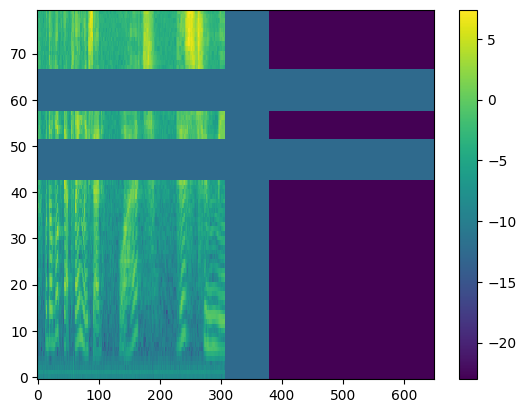

In [19]:
# 1600: [96, 1656, 80]
# 4000: [241, 1656, 80]
x = feature[500]
im = plt.imshow(x.transpose(0,1).cpu().numpy(), origin='lower', interpolation='nearest', aspect='auto')
plt.colorbar(im)
plt.show()

In [46]:
for test_set, test_dl in test_dl_dict.items():
    for batch_idx, batch in enumerate(test_dl):
        feature = batch["inputs"].to(device=device, dtype=dtype)
        feature_lens = batch["supervisions"]["num_frames"].to(device)
        texts = batch["supervisions"][params.cutset_text]

        x = nn.functional.pad(feature, (0, 0, 4, 0), value=LOG_EPSILON)
        x = (x - model.encoder.mean) * model.encoder.rstd
        x = x.transpose(1, 2)
        # out = model.encoder.conv_pre.conv[0](x)
        # out = model.encoder.conv_pre.conv[1](out)
        out, l = model.encoder.conv_pre(x, feature_lens)
        for idx_block, block in enumerate(model.encoder.cnn):
            out, l = block(out, l, 1.0)
            if idx_block == 5:
                break
        block = model.encoder.cnn[idx_block+1]
        out = block.norm0(out)
        out = block.pointwise1(out)
        out = block.activation(out)
        out = block.norm1(out)
        # out = block.depthwise(out)
        # out = block.activation(out)
        # out = block.norm2(out)
        break
    break

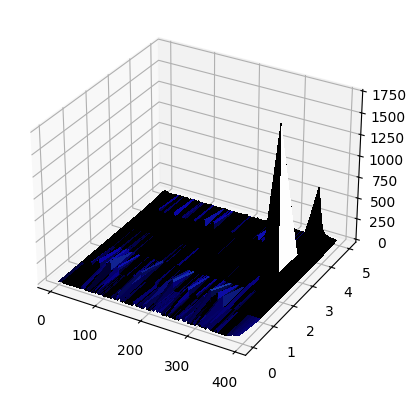

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import cm
import numpy as np

out = out.abs()
out_argmax = out.argmax().item()
idx_b = out_argmax // (out.shape[1]*out.shape[2])
idx_c = out_argmax // out.shape[2] % out.shape[1]
# z = out[max(idx_b-2, 0):idx_b+2, :, :].transpose(0, 1).detach()
z = out[idx_b:idx_b+1, max(idx_c - 3, 0):idx_c+3, :].transpose(0,1).detach()
z = z.reshape(z.size(0), -1).cpu().numpy()
i = np.arange(0, z.shape[0])
j = np.arange(0, z.shape[1])
x, y = np.meshgrid(j, i)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()

In [39]:
print(z.shape, out.shape, idx_b, idx_c)
block.norm2.running_var[idx_c-10:idx_c+10]

(6, 394) torch.Size([12, 1024, 394]) 8 707


tensor([0.8381, 0.1757, 0.3314, 0.5881, 0.2694, 0.2018, 0.2727, 1.0352, 0.0050,
        0.2103, 0.2638, 0.3996, 0.3141, 0.1209, 0.0492, 0.1087, 0.5332, 0.1848,
        0.2192, 0.0105])